# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). Remember that you will have to defend the assignment at the end of the semester.
- **Deadline is November 26**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name:**  Farid Ibrahimli

**Neptun ID:** DQWMYW

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
# ADD YOUR CODE HERE
import numpy as np
import math
from typing import List
import os
import argparse
import glob
import shutil
import torchvision.datasets as datasets
import torch.utils.data as loader
from torchvision import models
import torch
import torch.nn as nn
import time
import torch.optim as optim
from PIL import Image
import requests
import matplotlib.pyplot as plt

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset
Show some images and annotations of your dataset

In [101]:
#Transformation
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])



data = datasets.VOCSegmentation(root = '/mydata', year = '2007', image_set = 'test', download = True, transform=trf )

Using downloaded and verified file: /mydata/VOCtest_06-Nov-2007.tar
Extracting /mydata/VOCtest_06-Nov-2007.tar to /mydata


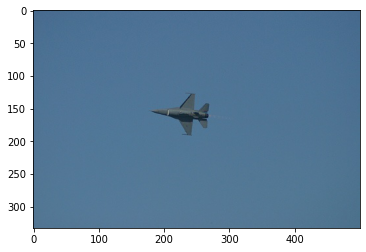

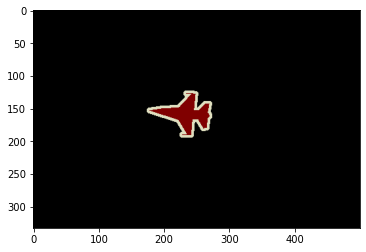

In [97]:
img = Image.open(data.images[2])
plt.imshow(img); plt.show()

inp = trf(img).unsqueeze(0)


tar = Image.open(data.targets[2])
plt.imshow(tar); plt.show()

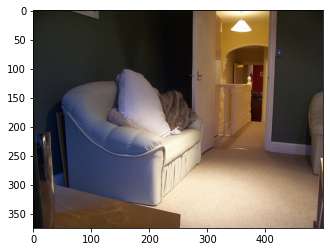

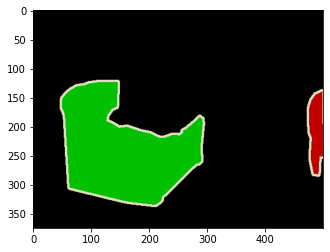

In [143]:
img = Image.open(data.images[7])
plt.imshow(img); plt.show()

inp = trf(img).unsqueeze(0)


tar = Image.open(data.targets[7])
plt.imshow(tar); plt.show()

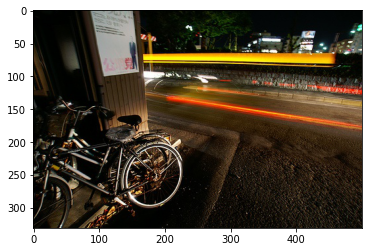

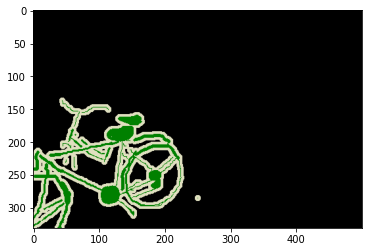

In [149]:
img = Image.open(data.images[10])
plt.imshow(img); plt.show()

inp = trf(img).unsqueeze(0)


tar = Image.open(data.targets[10])
plt.imshow(tar); plt.show()


## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

In [3]:
resnetbackbone = models.resnet101(pretrained=True).eval()


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [122]:
mobilenetbackbone = models.mobilenet_v3_large(pretrained=True).eval()


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [4]:

model1 = models.segmentation.fcn_resnet101(pretrained=True).eval()
model2 = models.segmentation.lraspp_mobilenet_v3_large(pretrained=True).eval() 
model3 = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth


  0%|          | 0.00/12.5M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

### Question 1
Describe the main differences between the models you chose.

ADD ANSWER HERE

In [48]:
Question 1:
                              Mean IoU:    Global Pixelwise Accuracy:
FCN ResNet101:                  63.7       91.9
DeepLabV3 ResNet101:            67.4       92.4
LR-ASPP MobileNetV3-Large:      57.9       91.2


In [99]:
def segment(net, path, show_orig=True, dev='cpu'):
  img = Image.open(path)
  #if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(375), 
                   T.CenterCrop(375), 
                   T.ToTensor()])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  return om
  #plt.imshow(rgb); plt.axis('off'); plt.show()


### 3. **Evaluation**
This is the most important part. Please give a detailed comparison between the models.

Define your metrics manually. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

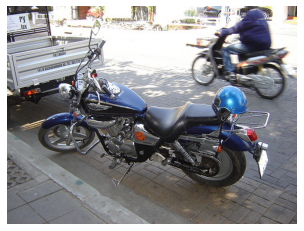

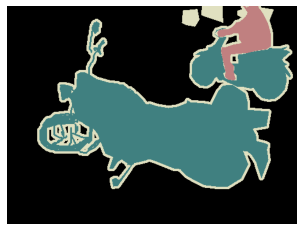

In [127]:
plt.imshow(Image.open(data.images[5])); plt.axis('off'); plt.show()
plt.imshow(Image.open(data.targets[5])); plt.axis('off'); plt.show()


### **FCN resnet**

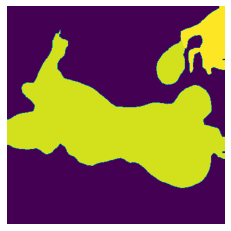

In [128]:
plt.imshow(segment(model1, data.images[5])); plt.axis('off'); plt.show()

### **LRaspp**

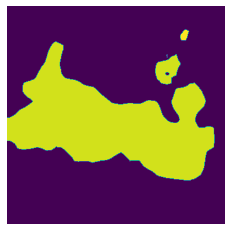

In [129]:
plt.imshow(segment(model2, data.images[5])); plt.axis('off'); plt.show()

### **DeepLab**

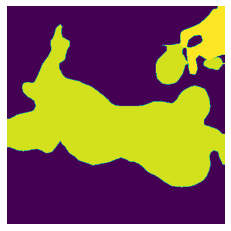

In [130]:
plt.imshow(segment(model3, data.images[5])); plt.axis('off'); plt.show()

# **Show the metrics results**

## **Inference time**

In [100]:
import time

def infer_time(net, path, dev='cpu'):
  img = Image.open(path)
  trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  
  inp = trf(img).unsqueeze(0).to(dev)
  
  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()
  
  return et - st

In [115]:
def giveDataToModel(datas, model):
  sum=0
  counter=0
  for img  in datas.images:
   a = infer_time(model1, img)
   sum+=a
   counter+=1
  return (sum/(counter+1))  

In [103]:
 pa = giveDataToModel(data, model1)
 print(pa)

1.4396288790409033


In [116]:
 pa = giveDataToModel(data, model2)
 print(pa)

1.5000750623043115


In [117]:
 pa = giveDataToModel(data, model3)
 print(pa)

1.5513440534401843


### **Inference time on CPU**

In [139]:
def giveDataToModel(datas, model):
  sum1 = .0
  counter=0
  for img  in datas.images:
    avg_over = 2
    fcn_infer_time_list_cpu = [infer_time(model1, img, dev='cpu') for _ in range(avg_over)]
    fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over
    a = fcn_infer_time_avg_cpu
    sum1 += a
    counter+=1
  print ('The Average Inference time on This model is:  {:.2f}s'.format(sum1/(counter+1)))


In [140]:
giveDataToModel(data, model1)

The Average Inference time on This model is:  1.56s


In [141]:
giveDataToModel(data, model2)

The Average Inference time on This model is:  1.53s


In [142]:
giveDataToModel(data, model3)

The Average Inference time on This model is:  1.56s


### **Model size**

In [138]:
import os

resnet101_size = os.path.getsize('/root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth')
mobilenet_size = os.path.getsize('/root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth')
lraspp_size = os.path.getsize('/root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth')
fcn_size = os.path.getsize('/root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth')
dlab_size = os.path.getsize('/root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth')

fcn_total = fcn_size + resnet101_size
dlab_total = dlab_size + resnet101_size

print ('Size of the FCN model with Resnet101 backbone is:       {:.2f} MB'.format(fcn_total /  (1024 * 1024)))
print ('Size of the DeepLabv3 model with Resnet101 backbone is: {:.2f} MB'.format(dlab_total / (1024 * 1024)))
print ('Size of the LR-aspp model with Mobilenet backbone is: {:.2f} MB'.format((lraspp_size + mobilenet_size) / (1024 * 1024)))



Size of the FCN model with Resnet101 backbone is:       378.22 MB
Size of the DeepLabv3 model with Resnet101 backbone is: 403.73 MB
Size of the LR-aspp model with Mobilenet backbone is: 33.60 MB


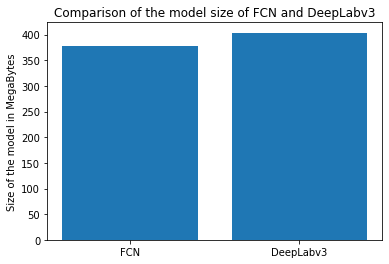

In [137]:
plt.bar([0, 1], [fcn_total / (1024 * 1024), dlab_total / (1024 * 1024)])
plt.ylabel('Size of the model in MegaBytes')
plt.xticks([0, 1], ['FCN', 'DeepLabv3'])
plt.title('Comparison of the model size of FCN and DeepLabv3')
plt.show()

## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

#### Question 3. 
How could you improve the performance of the models?

ADD ANSWERS HERE

In [ ]:
Question 2:
According to the results and metrics model3 is best, second best is model1. 
Actually although model1 is quite similar to model3 because they have the same backbone but because of size I think model3 performns better.
However model2 is a bit behind from them. 
Although its output is successfull, but it is not so accurate like others. 
It shows that resnet architecture is better than mobilenet on VOC dataset.

In [ ]:
Question 3:
I think by increasing the size of dataset we can get better performance results.